In [ ]:
from google.colab import drive

In [ ]:
!pip install av
import av

# Load Dependencies



In [ ]:
# UCF 101 Classes
class_txt = """1 ApplyEyeMakeup
2 ApplyLipstick
3 Archery
4 BabyCrawling
5 BalanceBeam
6 BandMarching
7 BaseballPitch
8 Basketball
9 BasketballDunk
10 BenchPress
11 Biking
12 Billiards
13 BlowDryHair
14 BlowingCandles
15 BodyWeightSquats
16 Bowling
17 BoxingPunchingBag
18 BoxingSpeedBag
19 BreastStroke
20 BrushingTeeth
21 CleanAndJerk
22 CliffDiving
23 CricketBowling
24 CricketShot
25 CuttingInKitchen
26 Diving
27 Drumming
28 Fencing
29 FieldHockeyPenalty
30 FloorGymnastics
31 FrisbeeCatch
32 FrontCrawl
33 GolfSwing
34 Haircut
35 HammerThrow
36 Hammering
37 HandstandPushups
38 HandstandWalking
39 HeadMassage
40 HighJump
41 HorseRace
42 HorseRiding
43 HulaHoop
44 IceDancing
45 JavelinThrow
46 JugglingBalls
47 JumpRope
48 JumpingJack
49 Kayaking
50 Knitting
51 LongJump
52 Lunges
53 MilitaryParade
54 Mixing
55 MoppingFloor
56 Nunchucks
57 ParallelBars
58 PizzaTossing
59 PlayingCello
60 PlayingDaf
61 PlayingDhol
62 PlayingFlute
63 PlayingGuitar
64 PlayingPiano
65 PlayingSitar
66 PlayingTabla
67 PlayingViolin
68 PoleVault
69 PommelHorse
70 PullUps
71 Punch
72 PushUps
73 Rafting
74 RockClimbingIndoor
75 RopeClimbing
76 Rowing
77 SalsaSpin
78 ShavingBeard
79 Shotput
80 SkateBoarding
81 Skiing
82 Skijet
83 SkyDiving
84 SoccerJuggling
85 SoccerPenalty
86 StillRings
87 SumoWrestling
88 Surfing
89 Swing
90 TableTennisShot
91 TaiChi
92 TennisSwing
93 ThrowDiscus
94 TrampolineJumping
95 Typing
96 UnevenBars
97 VolleyballSpiking
98 WalkingWithDog
99 WallPushups
100 WritingOnBoard
101 YoYo"""

In [ ]:
split = class_txt.split("\n")

In [ ]:
idx_to_class = {}
class_to_idx = {}
cur_idx = 0
for txt in split:
  if cur_idx +1 >99:
    class_val = txt[4:]
  elif cur_idx + 1 > 9:
    class_val = txt[3: ]
  else:
    class_val = txt[2: ]
  class_to_idx[class_val] = cur_idx
  idx_to_class[cur_idx] = class_val
  cur_idx += 1

In [ ]:
%%capture
!pip install livelossplot
!pip install kaggle
import livelossplot
!pip install transformers
import transformers
import math
import time
import random
import copy
import cv2
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import tqdm.notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
# please upload your kaggle key to colab first.
!mkdir /root/.kaggle/
!cp ./kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Load and Process the Dataset, DO NOT INTERPOLATE THIS TIME
It seems that the interpolation of video frames really distorted the videos, and thus we will use sample rather than interpolate

In [ ]:
transform_dataloader = torchvision.transforms.Resize((96, 96))
transform_augment = torchvision.transforms.Compose([
  torchvision.transforms.ColorJitter(0.01, 0.01, 0.01, 0.01),
  torchvision.transforms.RandomRotation(5)
])

In [ ]:
# Download the UCF101 dataset
!kaggle datasets download -d pevogam/ucf101
!unzip ucf101.zip
!rm -f ucf101.zip

In [ ]:
ucf_data = torchvision.datasets.UCF101("./UCF101/UCF-101", "/content/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist", 16)

In [ ]:
ucf_data = torch.load("./train_data.pth")

In [ ]:
dataloader = torch.utils.data.DataLoader(ucf_data, batch_size = 1)

In [ ]:
train_sub, test_sub, val_sub = torch.utils.data.random_split(dataloader.dataset, [len(dataloader) - 64, 32, 32]) # Create Train, Val, and Test Splits

In [ ]:
trainloader = torch.utils.data.DataLoader(train_sub, batch_size = 1, shuffle = True)
valloader = torch.utils.data.DataLoader(val_sub)
testloader = torch.utils.data.DataLoader(test_sub)

In [ ]:
torch.save(trainloader, "./trainloader.pth")
torch.save(valloader, "./valloader.pth")
torch.save(testloader, "./testloader.pth")

In [ ]:
trainloader = torch.load("./trainloader.pth")
valloader = torch.load("./valloader.pth")
testloader = torch.load("./testloader.pth")

In [ ]:
def prepare_video(videos, transform = None):
  '''
  videos: List of videos, each of size(1, T, H, W, 3)
  returns: tensor(B, 3, T, 96, 96)
  '''
  video_prepared = []
  for video_frame in videos:
    # video: Tensor(1, T, H, W, 3)
    video_frame = torch.squeeze(video_frame, dim = 0) # (T, H, W, 3)
    video_frame = video_frame.transpose(2, 3).transpose(1, 2) # (T, 3, H, W), we will treat T like a bacth
    resized_video = transform_dataloader(video_frame) # (T, 3, 96, 96)
    if transform:
      video_prepared += [transform(resized_video)]
    else:
      video_prepared += [resized_video]
  return torch.stack(video_prepared).transpose(1, 2)    

In [ ]:
def display_video(video):
  '''
  displays a video, for data visualization
  Video: Tensor(L, 3, H, W)
  '''
  L, _, _, _ = video.shape
  for i in range(L):
    frame = video[i, :, :, :].transpose(0, 1).transpose(1, 2)
    plt.imshow(frame)
    plt.show()

In [ ]:
def sample_from_dataloader(dataloader, num_samples, transform):
  count = 0
  video_batch = []
  cls_batch = []
  for video, audio, cls in dataloader:
    video_batch += [video]
    cls_batch += [cls]
    count += 1
    if count == num_samples:
      break
  return prepare_video(video_batch), torch.cat(cls_batch)

Visualize Data

In [ ]:
video, cls = sample_from_dataloader(valloader, 32, transform_augment)

/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."


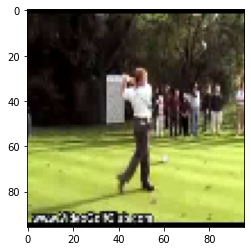

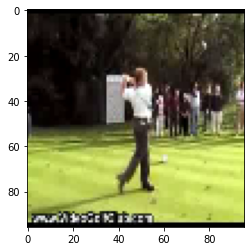

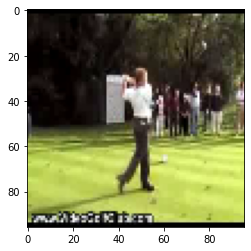

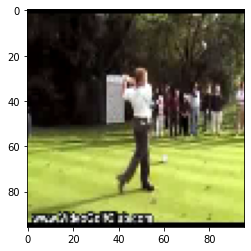

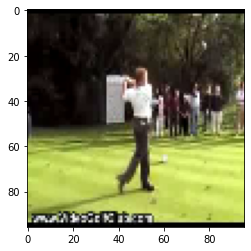

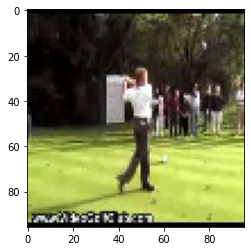

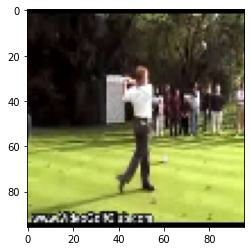

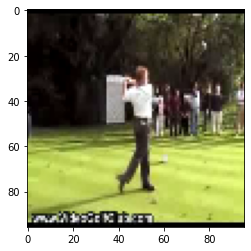

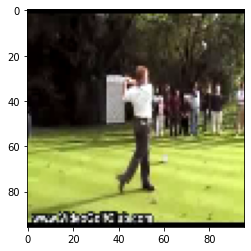

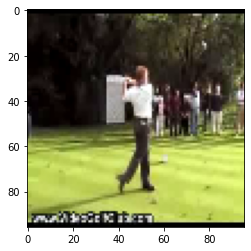

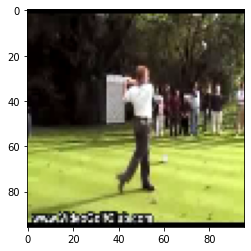

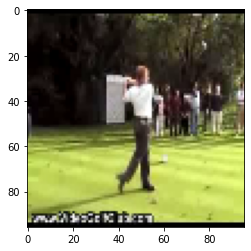

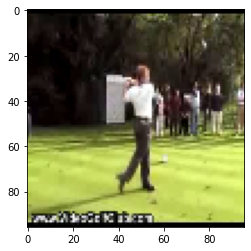

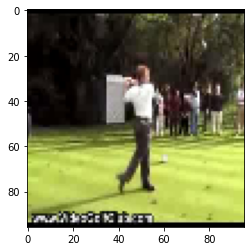

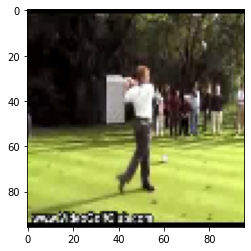

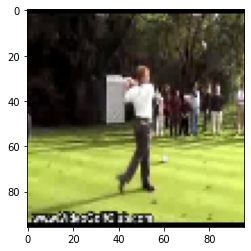

In [ ]:
display_video(video[2, :, :, :, :].transpose(0, 1))

# Simple 2D Single Frame CNN Architecture(Mobile Net v2), BaseLine Model

In [ ]:
class BatchNormBlock(nn.Module):
  def __init__(self, input_dim, output_dim, kernel_size, padding):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.kernel_size = kernel_size
    self.padding = padding
    self.conv = nn.Conv2d(input_dim, output_dim, kernel_size = kernel_size, padding = padding)
    self.bn = nn.GroupNorm(8, output_dim)
  def forward(self, x):
    return self.bn(F.relu(self.conv(x)))

In [ ]:
class InvertedBottleNeckBlock(nn.Module):
  def __init__(self, in_features, expanded_dim):
    # Expanded Dim should be larger than in_features
    super().__init__()
    self.in_features = in_features
    self.expanded_dim = expanded_dim
    self.expand = BatchNormBlock(self.in_features, self.expanded_dim, 1, 0)
    self.Depthwise = nn.Conv2d(self.expanded_dim, self.expanded_dim, kernel_size = 3, padding = 1, groups = self.expanded_dim)
    self.bn = nn.GroupNorm(8, self.expanded_dim)
    self.squeeze = nn.Conv2d(self.expanded_dim, self.in_features, kernel_size = 1)
    self.bn2 = nn.GroupNorm(8, self.in_features)
  def forward(self, x):
    expand = self.expand(x)
    depthwise = self.bn(F.relu(self.Depthwise(expand)))
    squeeze = self.bn2(F.relu(self.squeeze(depthwise) + x))
    return squeeze

In [ ]:
class MobileNetv2(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.num_classes = num_classes
    self.model = nn.Sequential(*[
      BatchNormBlock(3, 32, 3, 1),
      InvertedBottleNeckBlock(32, 128), # (B, 32, 96, 96)
      nn.MaxPool2d(kernel_size = 3, padding = 1, stride = 2), # (B, 32, 48, 48)
      BatchNormBlock(32, 16, 3, 1),
      InvertedBottleNeckBlock(16, 64),
      nn.MaxPool2d(kernel_size = 3, padding = 1, stride = 2), # (B, 16, 24, 24)
      BatchNormBlock(16, 64, 1, 0),
      InvertedBottleNeckBlock(64, 256),
      nn.MaxPool2d(kernel_size = 3, padding = 1, stride = 2), # (B, 64, 12, 12)
      BatchNormBlock(64, 256, 1, 0),
      InvertedBottleNeckBlock(256, 256),
      nn.MaxPool2d(kernel_size = 3, padding = 1, stride = 2),
      BatchNormBlock(256, 512, 1, 0) # (B, 512, 6, 6)
    ])
    self.Linear = nn.Linear(512, self.num_classes)
  def forward(self, x):
    '''
    x: Tensor(B, 3, 96, 96)
    '''
    features = self.model(x)
    max_pooled, _ = torch.max(features, dim = -1)
    max_pooled, _ = torch.max(max_pooled, dim = -1)
    return self.Linear(max_pooled)

In [ ]:
class VideoSingleCNN(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.num_classes = num_classes
    self.model = MobileNetv2(num_classes)
  def forward(self, x):
    '''
    Runs a forward pass through a Single Frame CNN 
    x: Tensor(B, 3, T, 96, 96)
    '''
    B, C, T, H, W = x.shape
    transposed_x = x.transpose(1, 2) # (B, T, 3, 96, 96)
    input_x = transposed_x.reshape(B * T, C, H, W)
    logits = self.model(input_x) # (BT, C)
    logits = logits.view(B, T, self.num_classes)
    avg_logits = torch.mean(logits, dim = 1)
    return avg_logits # (B, C)

In [ ]:
class Solver(nn.Module):
  def __init__(self, num_classes, device):
    super().__init__()
    self.device = device
    self.model = VideoSingleCNN(num_classes)
    self.optim = optim.Adam(self.model.parameters(), lr = 1e-3, weight_decay = 0.01)
    self.lr_decay = optim.lr_scheduler.ExponentialLR(self.optim, 0.9) # LR Decay
    self.criterion = nn.CrossEntropyLoss()
  def forward(self, x):
    '''
    x: Tensor(B, 3, T, H, W)
    '''   
    self.eval()
    with torch.no_grad():
      logits = F.softmax(self.model(x), dim = -1) # (B, C)
      _, pred_idx = torch.max(logits, dim = -1)
      return pred_idx
  def training_loop(self, trainloader, batch_size, validation, NUM_EPOCHS, display_every = 8):
    # Load in Validation Set
    validation_video, validation_GT = sample_from_dataloader(validation, len(validation), None)
    validation_video = validation_video.to(self.device).to(torch.float32)
    validation_GT = validation_GT.to(self.device).to(torch.float32)
    
    liveloss = livelossplot.PlotLosses()
    for EPOCH in range(NUM_EPOCHS):
      self.train()
      total_loss = 0
      for i in range(display_every):
        self.optim.zero_grad()
        input_video, input_GT = sample_from_dataloader(trainloader, batch_size, transform_augment)
        input_video = input_video.to(self.device).to(torch.float32)
        input_GT = input_GT.to(self.device).to(torch.float32)
        pred = self.model(input_video)
        loss = self.criterion(pred, input_GT.long())
        loss.backward()
        self.optim.step()
        total_loss += loss.item()
        del input_video
        del pred
        del input_GT
        torch.cuda.empty_cache()
      print(f"EPOCH {EPOCH}, loss: {total_loss / display_every}")
      if EPOCH % 100 == 0:
        self.lr_decay.step() # Decay Learning Rate every 100 epochs
      logs = {}
      logs['loss'] = total_loss / display_every
      # validation run
      self.eval()
      with torch.no_grad():
        pred = self.model(validation_video)
        val_loss = self.criterion(pred, validation_GT.long())
        del pred
      print(f"Validation: {val_loss}")
      logs["val_loss"] = val_loss
      liveloss.update(logs)
      liveloss.send()
    del validation_video
    del validation_GT
    torch.cuda.empty_cache()     

In [ ]:
%%capture
solver = Solver(len(idx_to_class), device)
solver.to(device)

In [ ]:
solver.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

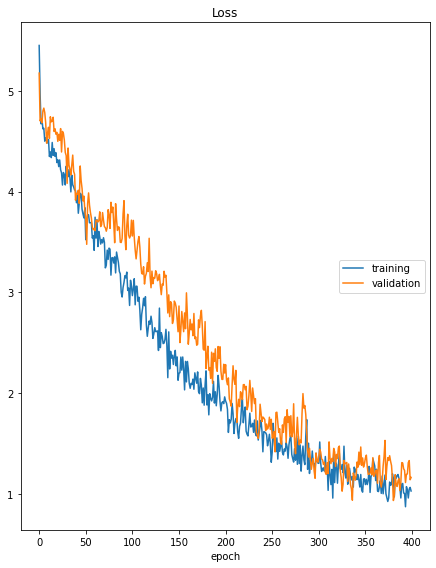

Loss
	training         	 (min:    0.872, max:    5.450, cur:    1.028)
	validation       	 (min:    0.934, max:    5.176, cur:    1.163)


In [ ]:
solver.training_loop(trainloader, 16, valloader, 400, display_every = 16)

In [ ]:
torch.save(solver.state_dict(), "./model.pth")

Test run:

State Dict will be uploaded for the simple CNN

In [ ]:
test_input, test_GT = sample_from_dataloader(testloader, 16, None)
test_input = test_input.to(device).to(torch.float32)

/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."


In [ ]:
pred = solver(test_input)

In [ ]:
pred

tensor([93,  8, 73, 21, 34, 25, 87, 46, 51, 43, 25, 98, 68, 73, 12, 68],
       device='cuda:0')

In [ ]:
test_GT

tensor([47,  8, 73, 48, 34, 40, 87, 46, 41, 97, 51, 98, 68, 73, 36, 47])

Decent Model, Can get a few of them correct.
7-8 Wrong on the test set. 8/16 Correct.

# VTN, or the Video Transformer Network(published Feb 2021)
For best results, we will leverage MobileNetv2 Transfer Learning on Image Net

In [ ]:
class NonLocalBlock(nn.Module):
  def __init__(self, num_heads, in_dim, inner_dim):
    super().__init__()
    self.num_heads = num_heads
    self.in_dim = in_dim
    self.inner_dim = inner_dim
    self.K = nn.Conv2d(self.in_dim, self.inner_dim * self.num_heads, kernel_size = 1)
    self.V = nn.Conv2d(self.in_dim, self.inner_dim * self.num_heads, kernel_size = 1)
    self.Q = nn.Conv2d(self.in_dim, self.inner_dim * self.num_heads, kernel_size = 1)
    self.Linear = nn.Conv2d(self.inner_dim * self.num_heads, self.in_dim, kernel_size = 1)
  def forward(self, x):
    '''
    x: Tensor(B, C, H, W)
    '''
    B, _, H, W = x.shape
    K = self.K(x)
    V = self.V(x)
    Q = self.Q(x) # (B, Inner_dim * Heads, H, W)

    K = K.view(B, self.num_heads, self.inner_dim, H, W)
    K = K.view(B * self.num_heads, self.inner_dim, H * W)

    V = V.view(B, self.num_heads, self.inner_dim, H, W)
    V = V.view(B * self.num_heads, self.inner_dim, H * W)

    Q = Q.view(B, self.num_heads, self.inner_dim, H, W)
    Q = Q.view(B * self.num_heads, self.inner_dim, H * W) # (B * Heads, Inner DIm, HW)

    att_mat = F.softmax(torch.bmm(K.transpose(1, 2), V) / math.sqrt(self.inner_dim), dim = -1)
    attended = torch.bmm(att_mat, V.transpose(1, 2)) # (B, HW, I)
    
    attended = attended.transpose(1, 2) # (B, I, HW)
    attended = attended.view(B, self.num_heads, self.inner_dim, H, W)
    return self.Linear(attended.reshape(B, self.inner_dim * self.num_heads, H, W))

In [ ]:
class FeatureExtractor(nn.Module):
  def __init__(self):
    super().__init__()
    self.mobileNetv2 = torchvision.models.mobilenet_v2(pretrained = True)
    self.feature_extractor = self.mobileNetv2.features[0: 14]
    for parameter in self.feature_extractor.parameters():
      parameter.requires_grad = False # Freeze Initial Features
    self.mobileNetv2 = None
    self.final_features = nn.Sequential(*[
      BatchNormBlock(96, 256, 1, 0),
      InvertedBottleNeckBlock(256, 512),
      NonLocalBlock(4, 256, 256),
      nn.MaxPool2d(kernel_size = 3, padding = 1, stride = 2),
      BatchNormBlock(256, 256, 1, 0),
      InvertedBottleNeckBlock(256, 256)
    ])
  def forward(self, x):
    '''
    Runs frame by frame feature extraction
    x: Tensor(B, 3, T, 96, 96)
    '''
    B, C, T, H, W= x.shape
    transpose_x = x.transpose(1, 2) # (B, T, 3, 96, 96)
    input_x = transpose_x.reshape(B * T, C, H, W) # (BT, 3, 96, 96)
    features = self.final_features(self.feature_extractor(input_x)) # (BT, 512, 3, 3)
    # Avg Pool each frame(to get a rough understanding of the model)
    avg, _ = torch.max(features, dim = -1)
    avg, _ = torch.max(avg, dim = -1) # Interchangable with torch.mean, i found that max pooling was better
    return avg.view(B, T, -1) # (B, T, 256) 

In [ ]:
class SelfAttention(nn.Module):
  '''
  Non Local Attention using 1x1 convolutions
  '''
  def __init__(self, num_heads, in_dim, inner_dim):
    super().__init__()
    self.num_heads = num_heads
    self.in_dim = in_dim
    self.inner_dim = inner_dim
    self.K = nn.Linear(self.in_dim, self.inner_dim * self.num_heads)
    self.V = nn.Linear(self.in_dim, self.inner_dim * self.num_heads)
    self.Q = nn.Linear(self.in_dim, self.inner_dim * self.num_heads) 
    self.Linear = nn.Linear(self.inner_dim * self.num_heads, self.in_dim)

  def forward(self, x):
    '''
    Dot Product Attention
    x: Tensor(B, L, C)
    '''
    B, L, C = x.shape
    K = self.K(x)
    V = self.V(x)
    Q = self.Q(x) # (B, L, self.num_heads * self.inner_dim)

    K = K.view(B, L, self.num_heads, self.inner_dim)
    V = V.view(B, L, self.num_heads, self.inner_dim)
    Q = Q.view(B, L, self.num_heads, self.inner_dim)

    K = K.transpose(1, 2) # (B, self.num_heads, L, self.inner_dim)
    V = V.transpose(1, 2) # (B, self.num_heads, L, self.inner_dim)
    Q = Q.transpose(1, 2) # (B, self.num_heads, L, self.inner_dim)

    K = K.reshape(B * self.num_heads, L, self.inner_dim)
    V = V.reshape(B * self.num_heads, L, self.inner_dim)
    Q = Q.reshape(B * self.num_heads, L, self.inner_dim) # (BH, L, C)

    att_mat = F.softmax(torch.bmm(K, Q.transpose(1, 2)) / math.sqrt(self.inner_dim))

    att_scores = torch.bmm(att_mat, V) # (BH, L, C)
    att_scores = att_scores.reshape(B, self.num_heads, L, self.inner_dim)
    att_scores = att_scores.transpose(1, 2) # (B, L, self.num_heads, self.inner_dim)
    return self.Linear(att_scores.reshape(B, L, -1))

In [ ]:
class Encoder(nn.Module):
  '''
  One Encoder Module
  '''
  def __init__(self, len_input, in_features, num_heads, device):
    super().__init__()
    self.device = device 
    self.in_features = in_features
    self.num_heads = num_heads
    self.SelfAttention = SelfAttention(self.num_heads, self.in_features, self.in_features)
    self.SelfAttNorm = nn.LayerNorm((len_input, self.in_features))
    self.Linear = nn.Linear(self.in_features, self.in_features)
    self.LinearNorm = nn.LayerNorm((len_input, self.in_features))
  def forward(self, x):
    '''
    Runs the Features through one encoder block.
    x: Tensor(B, L, 512)
    '''
    # Add Positional_encoding
    position_encodings = self.position_encoding(x) # (B, L, 512)
    position_encodings = position_encodings
    # Add to Features
    attended = self.SelfAttention(position_encodings) # (B, 512, L)
    attended = self.SelfAttNorm(attended + position_encodings)
    # Affine layer
    return self.LinearNorm(F.relu(self.Linear(attended) + attended))
  
  def position_encoding(self, x):
    '''
    x: Tensor(B, L, 512), where L represents the number of frames.
    returns: Tensor(B, L, 512)
    '''
    B, L, C = x.shape
    pos_enc = torch.zeros((L, C), device = self.device, dtype = torch.float32)
    for pos in range(L):
      for i in range(0, C, 2):
        pos_enc[pos, i] = math.sin(pos / 10000 ** (2 * i / self.in_features))
        pos_enc[pos, i + 1] = math.cos(pos / 10000 ** (2 * (i + 2) / self.in_features))
    batched_pos_enc = []
    for i in range(B):
      batched_pos_enc += [copy.deepcopy(pos_enc)]
    pos_enc = torch.stack(batched_pos_enc) # (B, L, 256)
    return x + pos_enc

In [ ]:
class Transformer(nn.Module):
  '''
  Transformer for VTN using Regular Attention.
  Note: The LongFormer Attention is unimplementable in Pytorch, so we use the regular one instead
  '''
  def __init__(self, len_input, num_encoders, in_features, device):
    super().__init__()
    self.device = device
    self.in_features = in_features
    self.num_encoders = num_encoders
    self.encoder = nn.Sequential(*[Encoder(len_input, self.in_features, 4, self.device) for i in range(self.num_encoders)])
  def forward(self, x):
    '''
    Processes the features
    x: Tensor(B, L, 512)
    '''
    return self.encoder(x)

In [ ]:
class VTN(nn.Module):
  '''
  VTN sample config.
  '''
  def __init__(self, len_input, num_classes, device):
    super().__init__()
    self.len_input = len_input
    self.num_classes = num_classes
    self.device = device
    self.feature_extractor = FeatureExtractor() # By itself, can be around pretty good(shown above)
    self.num_encoders = 5
    self.in_dim = 256
    self.model = Transformer(self.len_input, self.num_encoders, self.in_dim, self.device)
    self.Linear = nn.Linear(self.in_dim, self.num_classes)
  def forward(self, x):
    '''
    Processes a video and extracts its class.
    x: Tensor(B, 3, T, 96, 96)
    '''
    B, _, T, _, _ = x.shape
    features = self.feature_extractor(x) # (B, T, 512) 
    processed = self.model(features) # (B, T, 512)
    # Extract only the start token, NOTE: ADD THIS BACK
    start_token = torch.mean(processed, dim = 1) # (B, 512) 
    return self.Linear(start_token)
    

In [ ]:
class VTNSolver(nn.Module):
  def __init__(self, num_classes, device):
    super().__init__()
    self.num_classes = num_classes
    self.device = device
    self.model = VTN(16, self.num_classes, device)
    self.optim = optim.Adam(self.model.parameters(), lr = 1e-4, weight_decay = 0.01)
    self.lr_decay = optim.lr_scheduler.ExponentialLR(self.optim, 0.99)
    self.criterion = nn.CrossEntropyLoss()
  def forward(self, x):
    '''
    Runs inference on video
    x: Tensor(B, 3, T, 96, 96)
    '''
    self.eval()
    with torch.no_grad():
      pred = self.model(x) # (B, C)
      _, final = torch.max(pred, dim = -1)
      return final
  def training_loop(self, trainloader, valloader, batch_size, NUM_EPOCHS, display_every = 16):
    torch.cuda.empty_cache()
    # Load in the validation loader(32 max)
    validation_input, validation_GT = sample_from_dataloader(valloader, len(valloader), None)
    validation_input = validation_input.to(self.device).to(torch.float32)
    validation_GT = validation_GT.to(self.device).to(torch.long)  
    # begin Training
    liveloss = livelossplot.PlotLosses()
    for EPOCH in range(NUM_EPOCHS):
      self.train()
      total_loss = 0.0
      logs = {}
      for i in range(display_every):
        self.optim.zero_grad()
        input_video, input_GT = sample_from_dataloader(trainloader, batch_size, transform_augment)
        input_video = input_video.to(self.device).to(torch.float32)
        input_GT = input_GT.to(self.device).to(torch.long)

        pred = self.model(input_video) # (B, C)
        loss = self.criterion(pred, input_GT) 
        loss.backward()
        total_loss += loss.item()
        self.optim.step()
        del input_video
        del input_GT
        del pred
        del loss
        torch.cuda.empty_cache()
      logs['loss'] = total_loss / display_every
      print(f"EPOCH: {EPOCH}, loss: {logs['loss']}")    
      if EPOCH % 100 == 0:
        self.lr_decay.step() # Decay the lr every 100 EPOCHS
      self.eval()
      with torch.no_grad():
        pred = self.model(validation_input)
        loss = self.criterion(pred, validation_GT)
        del pred
      logs['val_loss'] = loss.item()
      del loss
      print(f"VALIDATION LOSS: {logs['val_loss']}")
      torch.cuda.empty_cache()
      liveloss.update(logs)
      liveloss.send()
    del validation_input
    del validation_GT
    torch.cuda.empty_cache()

Train the VTN

In [ ]:
torch.manual_seed(0) # For Reproducibility

In [ ]:
%%capture
solver = VTNSolver(101, device)
solver.to(device)

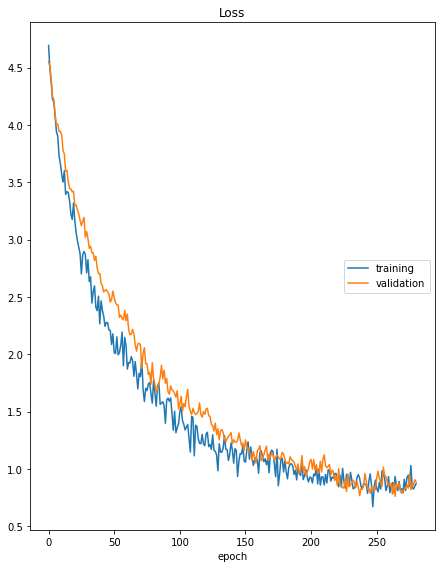

Loss
	training         	 (min:    0.669, max:    4.694, cur:    0.870)
	validation       	 (min:    0.760, max:    4.552, cur:    0.886)


In [ ]:
solver.training_loop(trainloader, valloader, 16, 400)

You can notice that this model trains in less epochs and converges better(Needs half the epochs to converge to the same loss)
Once again, the state dictionary of the model will be uploaded to Github.

In [ ]:
torch.save(solver.state_dict(), "./VTN.pth")

In [ ]:
solver.load_state_dict(torch.load("./VTN.pth"))

In [372]:
sample_input, sample_GT = sample_from_dataloader(testloader, 16, None)
sample_input = sample_input.to(device).to(torch.float32)

/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."


In [373]:
pred = solver(sample_input)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [374]:
pred

tensor([ 15,  61,  70,  61,  23,  46,  64, 100,  38,  63,  34,  73,  10,  64,
         73,  46], device='cuda:0')

In [375]:
sample_GT

tensor([ 15,  61,  70,  61,  14,  46,  64, 100,  38,  63,  34,  73,  10,  64,
         73,  46])

Only One incorrect! Very Good Accuracy on never before seen data! 15/16 Correct!

BlogPost and Github coming soon. Stay tuned.